## First approach to index retrieval

First I define my profile:

Running on cuda.


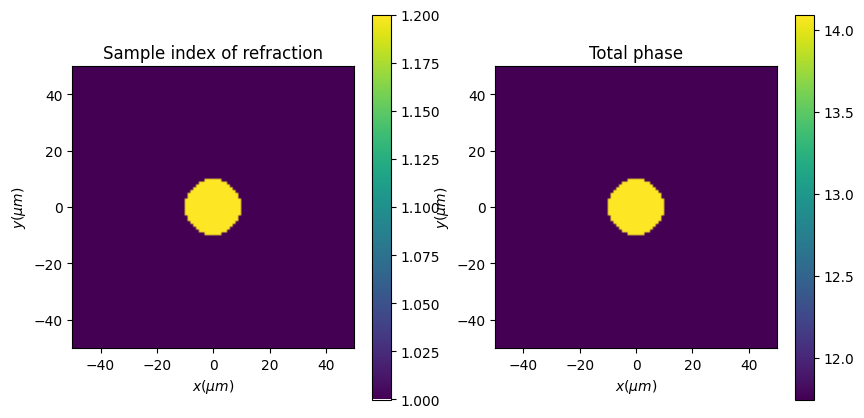

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}.")
# Define the grid
pix_size = 1e-6
W, H = (100, 100)
extent_obj = (pix_size * np.array([-W/2, W/2, -H/2, H/2]))

Y, X = np.mgrid[extent_obj[2]:extent_obj[3]:H*1j, 
                extent_obj[0]:extent_obj[1]:W*1j]

X = torch.tensor(X, device=device)
Y = torch.tensor(Y, device=device)

# Create the distribution of the sample
r1 = 1e-5
obj = torch.ones(H,W, device=device)
cond_circ1 = (X**2 + Y**2) <= r1**2
obj[cond_circ1] = 1.2

d = 1e-6
λ = 535e-9
sample = torch.exp(2j * np.pi * obj * d / λ)

fig, sub = plt.subplots(1,2, figsize = (10,5))
sub[0].set_title("Sample index of refraction")
im1 = sub[0].imshow(obj.cpu(), extent=extent_obj*1e6)
plt.colorbar(im1, ax=sub[0])
sub[1].set_title("Total phase")
#im2 = sub[1].imshow(2 * np.pi * obj * d / λ, extent=extent_obj*1e6)
im2 = sub[1].imshow(2 * np.pi * obj.cpu() * d / λ, extent=extent_obj*1e6)
plt.colorbar(im2, ax=sub[1])
for i in range(2):
    sub[i].set_xlabel("$x(\\mu m)$")
    sub[i].set_ylabel("$y(\\mu m)$")
plt.show()

Now I retrieve the index of refraction from the phase.

In [4]:
def complex_mse_loss(input, target):
    return ((input.real - target.real)**2 + (input.imag - target.imag)**2).mean()

guess = torch.ones(H,W, device=device, requires_grad=True)
loss_f = complex_mse_loss
d = 1e-6
λ = 535e-9

num_steps = 1000
optimizer = torch.optim.Adam([guess], lr=1e-3)

with tqdm(range(num_steps), desc="Optimizing") as pbar:
    for step in pbar:
        optimizer.zero_grad()
        prop_guess = torch.exp(2j * np.pi * guess * d / λ)
        loss = complex_mse_loss(prop_guess, sample)
        loss.backward()
        optimizer.step()
        
        # Update tqdm postfix with current loss
        pbar.set_postfix(loss=f"{loss.item():.6e}")

Optimizing: 100%|██████████| 1000/1000 [00:03<00:00, 295.33it/s, loss=4.032920e-12]


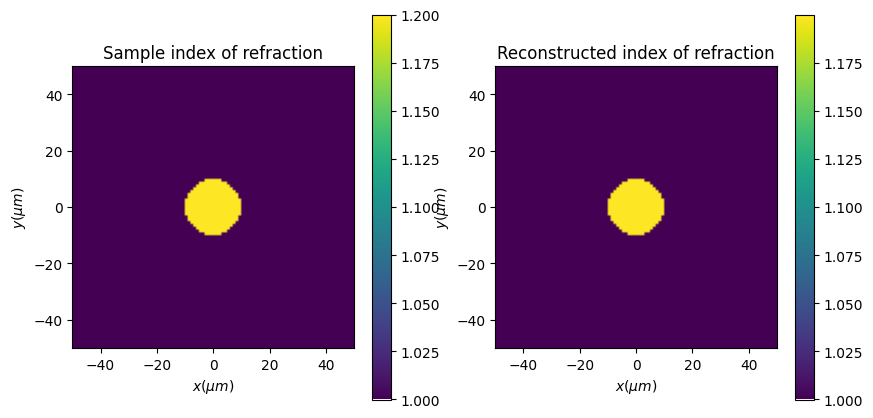

In [5]:
fig, sub = plt.subplots(1,2, figsize = (10,5))
sub[0].set_title("Sample index of refraction")
im1 = sub[0].imshow(obj.cpu(), extent=extent_obj*1e6)
plt.colorbar(im1, ax=sub[0])
sub[1].set_title("Reconstructed index of refraction")
#im2 = sub[1].imshow(2 * np.pi * obj * d / λ, extent=extent_obj*1e6)
im2 = sub[1].imshow(guess.cpu().detach().numpy(), extent=extent_obj*1e6)
plt.colorbar(im2, ax=sub[1])
for i in range(2):
    sub[i].set_xlabel("$x(\\mu m)$")
    sub[i].set_ylabel("$y(\\mu m)$")
plt.show()